In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale as sk_scale
from sklearn.preprocessing import StandardScaler

In [2]:
PATH = os.getcwd()
DATAPATH = os.path.join(PATH, "data")
filenames = {
    "X_test": "test_in - Copy.csv",
    "X_train": "train_in - Copy.csv",
    "y_test": "test_out - Copy.csv",
    "y_train": "train_out - Copy.csv",
}


# Import all data files
X_train = pd.read_csv(os.path.join(DATAPATH, filenames["X_train"]), header=None)
y_train = pd.read_csv(
    os.path.join(DATAPATH, filenames["y_train"]), header=None, names=["digit"]
)
X_test = pd.read_csv(os.path.join(DATAPATH, filenames["X_test"]), header=None)
y_test = pd.read_csv(
    os.path.join(DATAPATH, filenames["y_test"]), header=None, names=["digit"]
)

In [3]:
def center_img(X, y, digit: int):
    """Calculate the center of the cloud in 256 dim space for `digit` using data `X` and labels `y`"""
    return X[y.digit == digit].mean()


def show_img(X, shape=(16, 16)):
    """Show image of digit in `X`. Specifying the `shape` is optional"""
    plt.figure()
    plt.imshow(X.to_numpy().reshape(shape), cmap="Greys")
    plt.show()


def dist(src, dst):
    """Calculate the distance between `src` and `dst` using norm 2 distance"""
    return ((src - dst) ** 2).sum()


def classify(X_test, X_train=X_train, y_train=y_train):
    """Classify all test cases in `X_test` using the training data `X_train` and labels `y_train`"""
    centers = [center_img(X_train, y_train, digit) for digit in range(10)]
    output = []
    for _, img in X_test.iterrows():
        distances = [dist(img, center) for center in centers]
        output.append(np.argmin(distances))
    return pd.DataFrame(output, columns=["digit"])


def accuraccy(y_test: pd.DataFrame, y_out: pd.DataFrame):
    return len(y_test[y_test.eq(y_out).digit]) / len(y_test)


def calculate_distances(X_test, X_train=X_train, y_train=y_train) -> pd.DataFrame:
    """Classify all test cases in `X_test` using the training data `X_train` and labels `y_train`"""
    centers = [center_img(X_train, y_train, digit) for digit in range(10)]
    output = []
    for _, img in X_test.iterrows():
        output.append([dist(img, center) for center in centers])
    return pd.DataFrame(output)


def classify_dist_ij(dist_ij: pd.DataFrame, y: pd.DataFrame):
    """Classify all test cases using the distance matrix generated in `calculate_distances`"""
    return dist_ij.apply(np.argmin, axis=1).copy()

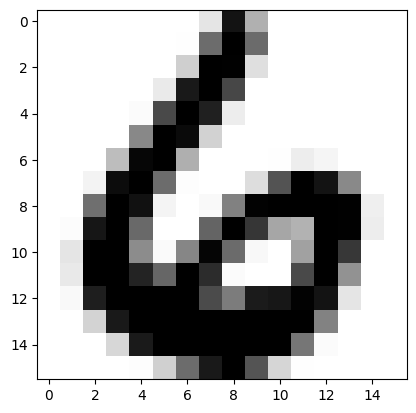

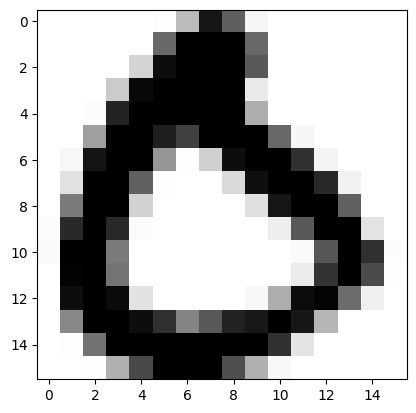

In [4]:
# Show first image in the training and test set to show data
show_img(X_train.iloc[0])
show_img(X_test.iloc[0])

# Task 1.1i: Calculate the centers

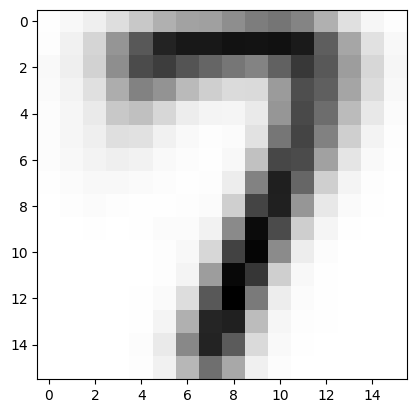

In [5]:
# Calculate center image of digits
center_7 = center_img(X_train, y_train, 7)
show_img(center_7)

# Task 1.1ii: Calculate the distances between the centers of the 10 clouds

In [6]:
centers = [center_img(X_train, y_train, digit) for digit in range(10)]
# Calculate all the distances for all possible combinations of centers
centers_dist = [
    dist(c1, c2)
    for i, c1 in enumerate(centers)
    for j, c2 in enumerate(centers)
    if i > j
]

# Task 1.1iii: What can you say about the expected accuraccy of the classifier?

In [7]:
# uhh

# Task 1.1iv: What pairs of digits seem to be most difficult to seperate?

In [8]:
arr = np.array(
    [
        (i, j, dist(c1, c2))
        for i, c1 in enumerate(centers)
        for j, c2 in enumerate(centers)
        if i > j
    ],
    dtype=[("digit1", int), ("digit2", int), ("distance", int)],
).T
np.sort(arr, order="distance")

array([(9, 7,  29), (9, 4,  36), (5, 3,  37), (9, 8,  40), (6, 5,  44),
       (8, 5,  48), (8, 3,  49), (8, 2,  50), (6, 2,  53), (8, 4,  54),
       (5, 0,  56), (7, 4,  57), (4, 2,  62), (5, 2,  62), (5, 4,  64),
       (3, 2,  66), (6, 0,  66), (9, 5,  68), (9, 3,  69), (8, 7,  71),
       (8, 6,  73), (6, 4,  77), (7, 2,  78), (9, 2,  78), (7, 3,  79),
       (4, 3,  82), (3, 0,  83), (7, 5,  84), (6, 3,  86), (2, 0,  87),
       (8, 0,  98), (9, 1,  98), (8, 1, 101), (2, 1, 102), (4, 1, 103),
       (9, 6, 108), (6, 1, 112), (4, 0, 115), (7, 1, 115), (7, 6, 118),
       (5, 1, 123), (9, 0, 131), (3, 1, 137), (7, 0, 140), (1, 0, 208)],
      dtype=[('digit1', '<i4'), ('digit2', '<i4'), ('distance', '<i4')])

# Task 1.2i: PCA

In [9]:
pca = PCA(n_components=2)
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
pca_train = pd.DataFrame(pca.fit_transform(X_train_norm))
X_test_norm = scaler.fit_transform(X_test)
pca_test = pd.DataFrame(pca.fit_transform(X_test_norm))
acc = accuraccy(y_test, classify(pca_test, X_train=pca_train))

print(f"The accuraccy with 2 component PCA is: {acc:.3f}")

The accuraccy with 2 component PCA is: 0.297


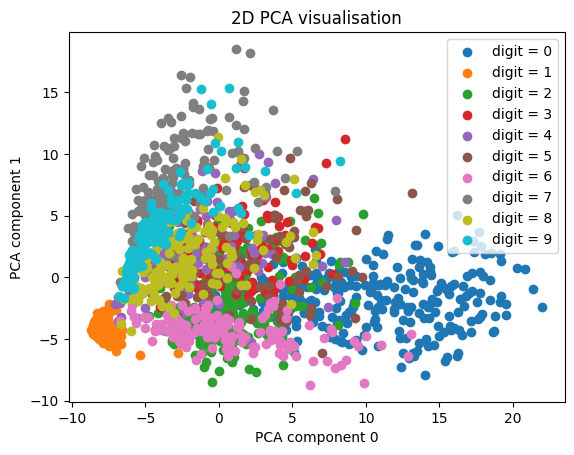

In [10]:
plt.figure()
plt.title("2D PCA visualisation")
plt.xlabel("PCA component 0")
plt.ylabel("PCA component 1")
for digit in range(10):
    plt.scatter(pca_train.loc[y_train.digit==digit, 0], pca_train.loc[y_train.digit==digit, 1], label=f"{digit = }")
plt.legend()
plt.show()

# Task 1.2ii: U-MAP

# Task 1.2iii: T-SNE

In [13]:
tsne = TSNE(n_components=2)
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
tsne_train = pd.DataFrame(tsne.fit_transform(X_train_norm))
X_test_norm = scaler.fit_transform(X_test)
tsne_test = pd.DataFrame(tsne.fit_transform(X_test_norm))
acc = accuraccy(y_test, classify(tsne_test, X_train=tsne_train))

print(f"The accuraccy with 2 component PCA is: {acc:.3f}")

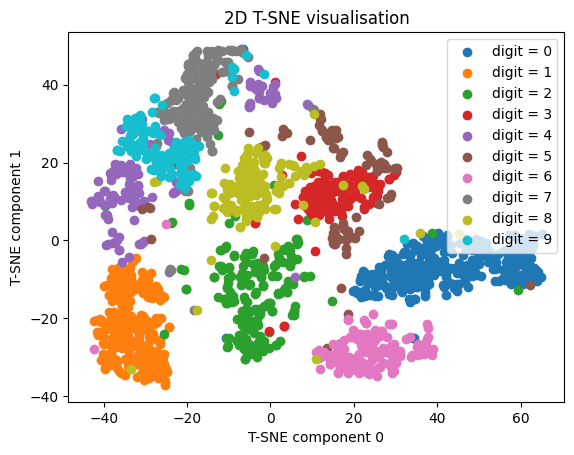

In [12]:
plt.figure()
plt.title("2D T-SNE visualisation")
plt.xlabel("T-SNE component 0")
plt.ylabel("T-SNE component 1")
for digit in range(10):
    plt.scatter(tsne_train.loc[y_train.digit==digit, 0], tsne_train.loc[y_train.digit==digit, 1], label=f"{digit = }")
plt.legend()
plt.show()